In [1]:
# General imports
import numpy as np
import pylab as plt
from scipy.interpolate import interp1d
from scipy.special import zeta
from enum import Enum

import imageio
import os
from IPython.display import Image

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import rc
rc('text', usetex=True)
rc('font', **{'family': 'serif', 'serif': ['cmr10']})

import matplotlib as mpl
mpl.rcParams['text.latex.preamble'] = r'\usepackage{{amsmath}}'

In [2]:
# Choose Gamma and m_nuL here
Gamma = 244.87 # in km/s/Mpc
m_nuL = 0.03   # in eV
is_ncdm_decay_degenerate = "yes" #choose between "yes" or "no"
neutrino_hierarchy = "normal"    #choose between "normal" or "inverted"
decay_mass_gap = "atmospheric"   #choose between "atmospheric" or "solar"

In [3]:
# Compute some quantities that we will need later
_k_B_        = 1.3806504e-23
_eV_         = 1.602176487e-19
_c_          = 2.99792458e8 
T_cmb        = 2.7255
T_ncdm_ratio = 0.71611
H0           = 67.37
Omega_m      = 0.3146
Delta_m2_atmos = 2.5e-3
Delta_m2_solar = 7.5e-5

Nq_interp = 1000


if decay_mass_gap == "atmospheric":
    Delta_m2 = Delta_m2_atmos
else:
    Delta_m2 = Delta_m2_solar

m_nuH = np.sqrt(m_nuL**2 + Delta_m2)
# change to CLASS units
m_nuH_rescaled = m_nuH*_eV_/(_k_B_*T_ncdm_ratio*T_cmb)
m_nuL_rescaled = m_nuL*_eV_/(_k_B_*T_ncdm_ratio*T_cmb)

a_NR = 3.15/m_nuH_rescaled 
#Equivalent to eq. 6 in https://arxiv.org/pdf/1003.0942

if is_ncdm_decay_degenerate == "yes" and neutrino_hierarchy == "normal":
    Gamma_rescaled = 2.*Gamma/H0
else:
    Gamma_rescaled = Gamma/H0 
    
if Gamma_rescaled > 1:
    a_decay = (1.+(-1.+Gamma_rescaled**2.)/Omega_m)**(-1./3.) 
#This comes from setting Gamma/H(a)=1, assuming a M+Lambda universe for H(a) (i.e. neglect back-reaction of decay) 
else:
    a_decay = 1. 

In [4]:
def read_background(file_path, q_ratio, get_PSD_at_manyz = False, num_snapshots = 30):
    
    pref = ((2 * np.pi)**3)/2 
    q_size = len(q_ratio)
    q_max = np.max(q_ratio)

    with open(file_path, 'r') as file:
        line_count = 0
        all_columns_bg = []

        for line in file:
            line_count += 1
            if line_count <= 4:
                continue

            columns = line.split()

            if len(all_columns_bg) == 0:
                all_columns_bg = [[] for _ in range(len(columns))]
            elif len(all_columns_bg) != len(columns):
                all_columns_bg.extend([] for _ in range(len(columns) - len(all_columns_bg)))

            for j, column_data in enumerate(columns):
                all_columns_bg[j].append(float(column_data))

    if is_ncdm_decay_degenerate == "yes":
        lnf_all = [all_columns_bg[18 + q_size + i] for i in range(q_size)]
    else:
        lnf_all = [all_columns_bg[21 + q_size + i] for i in range(q_size)]
    
    if get_PSD_at_manyz == False:
        lnf_s = [sublist[-1] for sublist in lnf_all]
    else:
        a_vector = np.array(all_columns_bg[1]) 
        H_vector = np.array(all_columns_bg[4]) 
        a_vector_NR = a_vector[a_vector>a_NR] #start recording PSD only when parent is non-relat, i.e. at a>a_NR
        idx_snapshots = np.linspace(len(a_vector)-len(a_vector_NR), len(a_vector)-1, num_snapshots, dtype=int,endpoint=True)
        a_snapshots = a_vector[idx_snapshots]
        H_snapshots = H_vector[idx_snapshots]*(_c_/1.e3)
        lnf_s = [np.array(sublist)[idx_snapshots] for sublist in lnf_all]
    
    lnf_d = np.array(lnf_s, dtype=float)
    f_l = pref * np.exp(lnf_d)

    if is_ncdm_decay_degenerate == "yes":
        lnf_all = [all_columns_bg[15 + i] for i in range(q_size)]
    else:
        lnf_all = [all_columns_bg[18 + i] for i in range(q_size)]

    
    if get_PSD_at_manyz == False:
        a_vector = np.array(all_columns_bg[1]) 
        closest_idx_adecay = np.argmin(np.abs(a_vector - a_decay))
        lnf_s = [sublist[closest_idx_adecay] for sublist in lnf_all]
    else:
        lnf_s = [np.array(sublist)[idx_snapshots] for sublist in lnf_all]
        
    lnf_d = np.array(lnf_s, dtype=float)
    f_h = pref * np.exp(lnf_d)
    
    q_int = np.linspace(q_max/Nq_interp, q_max, Nq_interp)

    if get_PSD_at_manyz == False:
        interp_func = interp1d(q_ratio, f_l, kind='cubic', fill_value='extrapolate')
        f_l = interp_func(q_int)
        interp_func1 = interp1d(q_ratio, f_h, kind='cubic', fill_value='extrapolate')
        f_h = interp_func1(q_int)
    else:
        f_l_snapshots = np.zeros((Nq_interp,num_snapshots))
        f_h_snapshots = np.zeros((Nq_interp,num_snapshots))
        for i in range(num_snapshots):
            interp_func = interp1d(q_ratio, f_l[:,i], kind='cubic', fill_value='extrapolate')
            f_l_snapshots[:,i] = interp_func(q_int)
            interp_func1 = interp1d(q_ratio, f_h[:,i], kind='cubic', fill_value='extrapolate')
            f_h_snapshots[:,i] = interp_func1(q_int)           
    
    if is_ncdm_decay_degenerate == "yes":
        n_nuL_0 = all_columns_bg[15 + q_size][-1]
        rho_nuL_0 = all_columns_bg[16 + q_size][-1]
    else:
        n_nuL_0 = all_columns_bg[18 + q_size][-1]
        rho_nuL_0 = all_columns_bg[19 + q_size][-1]        
   
    if get_PSD_at_manyz == False:
        return f_l,f_h,n_nuL_0,rho_nuL_0
    else:
        return f_l_snapshots,f_h_snapshots,a_snapshots,H_snapshots,n_nuL_0,rho_nuL_0

In [5]:
num_snapshots = 50

file_path = f"./CNB_calculations/output_CNB/testB1_g250_mL0p03_background.dat"

q_ratio = np.array([0.901961,1.80392,2.70588,3.60784,4.5098,5.41176,6.31373,7.21569,8.11765,9.01961,9.92157,10.8235,11.7255,12.6275,13.5294,14.4314,15.3333,16.2353,17.1373,18.0392,18.9412,19.8431,20.7451,21.6471,22.549,23.451,24.3529,25.2549,26.1569,27.0588,27.9608,28.8627,29.7647,30.6667,31.5686,32.4706,33.3725,34.2745,35.1765,36.0784,36.9804,37.8824,38.7843,39.6863,40.5882,41.4902,42.3922,43.2941,44.1961,45.098,46,48.4706,50.9412,53.4118,55.8824,58.3529,60.8235,63.2941,65.7647,68.2353,70.7059,73.1765,75.6471,78.1176,80.5882,83.0588,85.5294,88,90.4706,92.9412,95.4118,97.8824,100.353,102.824,105.294,107.765,110.235,112.706,115.176,117.647,120.118,122.588,125.059,127.529,130])
q_max = np.max(q_ratio)

fl_snap,fh_snap,a_snap,H_snap,n_nuL0,rho_nuL0 = read_background(file_path, q_ratio,
                                                                get_PSD_at_manyz = True,
                                                                num_snapshots = num_snapshots)

q_int = np.linspace(q_max/Nq_interp, q_max, Nq_interp)

In [6]:
#Create the GIF from the different PSD snapshots
output_folder = "PSD_snapshots"
os.makedirs(output_folder, exist_ok=True)
filenames = []

fontsize = 18
fontsize_title = 18
fontsize_tick = 14
power_q = 3

for i in range(num_snapshots):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,6),sharey=True,dpi=150)
    plt.subplots_adjust(wspace=0)
        
    ax1.set_title(r'$\nu_H$',fontsize=fontsize_title,pad=10)
    ax2.set_title(r'$\nu_L$',fontsize=fontsize_title,pad=10)

    ax1.plot(q_int, (q_int**power_q)*fh_snap[:,i],color='purple')
    ax2.plot(q_int, (q_int**power_q)*fl_snap[:,i],color='green')
    
    ax1.set_xlim([0,q_int[-1]])
    ax2.set_xlim([0,q_int[-1]])
    ax1.set_ylim([-0.1,1.5])
    ax2.set_ylim([-0.1,1.5])

    ax1.set_xlabel(r'$q$', fontsize=fontsize)
    ax2.set_xlabel(r'$q$', fontsize=fontsize)
    ax1.set_ylabel(r'$q^%d \bar{f}_i(q)$'%power_q, fontsize=fontsize,labelpad=10)
    [x.set_linewidth(1.5) for x in ax1.spines.values()]
    [x.set_linewidth(1.5) for x in ax2.spines.values()]
    ax1.tick_params(axis='both', which='major',direction="out",labelsize=fontsize_tick,size=4)
    ax2.tick_params(axis='both', which='major',direction="out",labelsize=fontsize_tick,size=4)

    ax1.text(50,1.15,r'$a$ = %.4f'%a_snap[i],fontsize=fontsize)
    ax1.text(46.6,1.01,r'$\Gamma/H$ = %.4f'%(2*Gamma/H_snap[i]),fontsize=fontsize)
    ax2.text(50,1.15,r'$a$ = %.4f'%a_snap[i],fontsize=fontsize)
    ax2.text(46.6,1.01,r'$\Gamma/H$ = %.4f'%(2*Gamma/H_snap[i]),fontsize=fontsize)
    
    ax1.annotate(r'$\Gamma = %.0f$ km/s/Mpc, \ \ $m_{\nu l}= %.2f$ eV, \ \ %s ordering, \ \ %s gap '%(Gamma,m_nuL,neutrino_hierarchy, decay_mass_gap),
            xy=(0.5, 0), xytext=(170, 413),
            xycoords=('axes fraction', 'figure fraction'),
            textcoords='offset points',
            size=fontsize_title, ha='center', va='bottom')
    
    filename = f"{output_folder}/frame_{i}.png"
    plt.savefig(filename)
    filenames.append(filename)
    plt.close()  # Close the plot to save memory

with imageio.get_writer("plot_PSD_evolution.gif", mode="I", duration=0.2) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

for filename in filenames:
    os.remove(filename)
os.rmdir(output_folder)

/Users/gfranco/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  del sys.path[0]
/Users/gfranco/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  del sys.path[0]


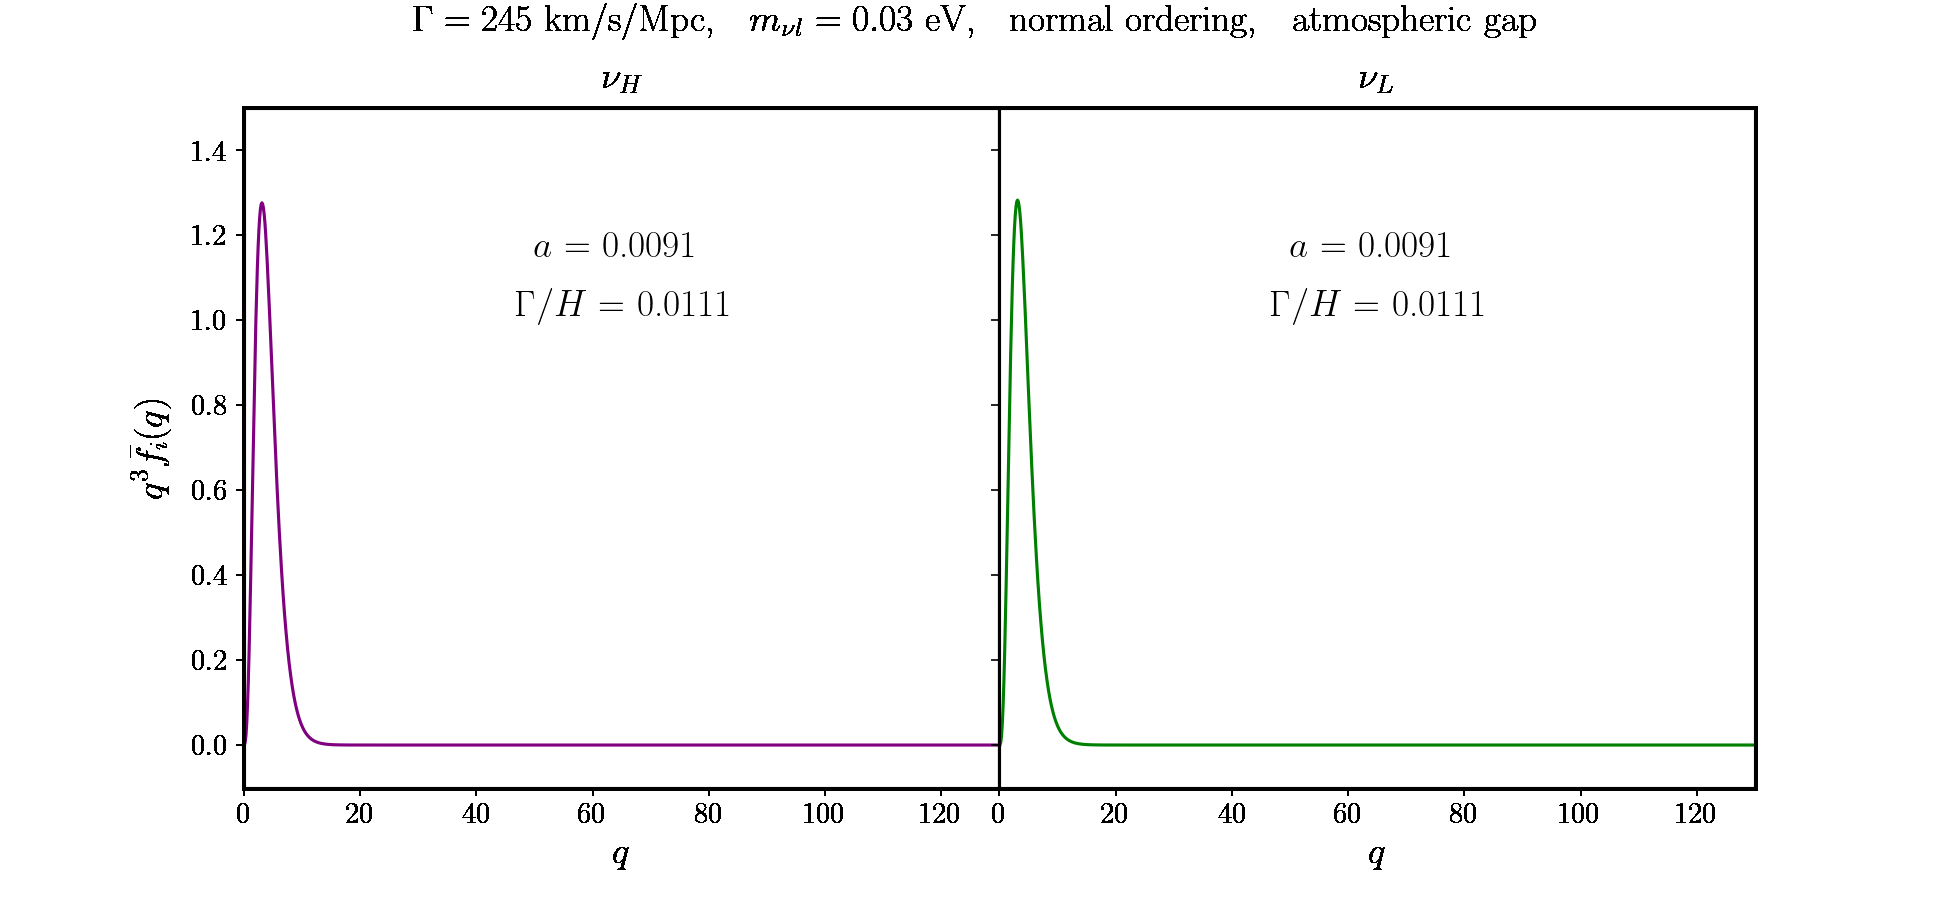

In [7]:
# plot the GIF
gif_path = "plot_PSD_evolution.gif"

Image(filename=gif_path)